# Laparoscopic Liver Surgery Simulation

In this notebook, a simulation is conducted, to illustrate the potential accuracy of a laparoscopic liver surgery system.

Aim: To simulate

![System Diagram](lap_liver_sim_diagram.jpg "System Diagram")

and see the accuracy.

In [305]:
%matplotlib inline

In [306]:
# Jupyter notebook sets the cwd to the folder containing the notebook.
# So, you want to add the root of the project to the sys path, so modules load correctly.
import sys
sys.path.append("../../")

In [307]:
# All imports.
import random
import copy
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R
import sksurgeryopencvpython as cvpy
import matplotlib.pyplot as plt

In [308]:
def extract_rigid_body_parameters(matrix):
    t = matrix[0:3, 3]
    r = matrix[0:3, 0:3]
    r = R.from_matrix(r)
    euler = r.as_euler('zyx', degrees=True)
    return [euler[0], euler[1], euler[2], t[0], t[1], t[2]]

def rigid_body_parameters_to_matrix(params):
    matrix = np.eye(4)
    r = (R.from_euler('zyx', [params[0], params[1], params[2]], degrees=True)).as_matrix()
    matrix[0:3, 0:3] = r
    matrix[0][3] = params[3]
    matrix[1][3] = params[4]
    matrix[2][3] = params[5]
    return matrix

def convert_camera_point_to_world(point, camera_to_marker, marker_to_world):
    return marker_to_world @ camera_to_marker @ point

def convert_4x1_to_1x1x3(p_41):
    p_113 = np.zeros((1,1,3))
    p_113[0][0][0] = p_41[0][0]
    p_113[0][0][1] = p_41[1][0]
    p_113[0][0][2] = p_41[2][0]
    return p_113

def convert_1x2_to_1x1x2(p_12):
    p_112 = np.zeros((1,1,2))
    p_112[0][0][0] = p_12[0]
    p_112[0][0][1] = p_12[1] 
    return p_112

def project_camera_point_to_image(point, intrinsics, distortion):
    rvec = np.zeros((1,3))
    tvec = np.zeros((1,3))
    image_points, jacobian = cv2.projectPoints(convert_4x1_to_1x1x3(point), rvec, tvec, intrinsics, distortion)
    return image_points[0][0] # returns a list
           
def convert_left_camera_to_right_camera(point, left_to_right):
    return left_to_right @ point

def triangulate_points_to_3d(left_point, left_intrinsic, left_distortion, right_point, right_intrinsic, right_distortion, left_to_right):
    left_point_undistorted = cv2.undistortPoints(convert_1x2_to_1x1x2(left_point), left_intrinsic, left_distortion, None, left_intrinsic)
    right_point_undistorted = cv2.undistortPoints(convert_1x2_to_1x1x2(right_point), right_intrinsic, right_distortion, None, right_intrinsic)
    image_points = np.zeros((1,4))
    image_points[0][0] = left_point_undistorted[0][0][0]
    image_points[0][1] = left_point_undistorted[0][0][1]
    image_points[0][2] = right_point_undistorted[0][0][0]
    image_points[0][3] = right_point_undistorted[0][0][1]
    reconstructed = cvpy.triangulate_points_using_hartley(image_points,
                                                          left_intrinsic,
                                                          right_intrinsic,
                                                          left_to_right[0:3, 0:3],
                                                          left_to_right[0:3, 3]
                                                          )
    result = np.ones((4,1))
    result[0][0] = reconstructed[0][0]
    result[1][0] = reconstructed[0][1]
    result[2][0] = reconstructed[0][2]
    return result                                   

def initialise_gold_standard(cam_x, cam_y, cam_z):
    point_in_left_camera_space = np.ones((4,1))
    point_in_left_camera_space[0][0] = cam_x
    point_in_left_camera_space[1][0] = cam_y
    point_in_left_camera_space[2][0] = cam_z
    point_in_right_camera_space = convert_left_camera_to_right_camera(point_in_left_camera_space, left_to_right)

    left_image_point = project_camera_point_to_image(point_in_left_camera_space, left_intrinsics, left_distortion)
    right_image_point = project_camera_point_to_image(point_in_right_camera_space, right_intrinsics, right_distortion)
    reconstructed = triangulate_points_to_3d(left_image_point, left_intrinsics, left_distortion, right_image_point, right_intrinsics, right_distortion, left_to_right)

    assert np.allclose(point_in_left_camera_space, reconstructed)

    gold_standard_world_point = convert_camera_point_to_world(point_in_left_camera_space, camera_to_marker, marker_to_world)
    return point_in_left_camera_space, gold_standard_world_point, left_image_point, right_image_point



# Load reference data.


This data comes from the SmartLiver system.

In [309]:
# Camera intrinsic calibration
left_intrinsics = np.loadtxt('lap_liver_left_intrinsics.txt')
left_distortion = np.loadtxt('lap_liver_left_distortion.txt')
right_intrinsics = np.loadtxt('lap_liver_right_intrinsics.txt')
right_distortion = np.loadtxt('lap_liver_right_distortion.txt')

# Hand-eye or, marker-to-camera
marker_to_camera = np.loadtxt('lap_liver_sim_marker_to_camera.txt')
camera_to_marker = np.linalg.inv(marker_to_camera)

# Its a stereo laparoscope, so separation between right and left camera.
left_to_right = np.loadtxt('lap_liver_sim_l2r.txt')

# And it's tracked, so, the marker to world transform.
marker_to_world = np.loadtxt('lap_liver_sim_marker_to_world.txt')

# Create Simulation Parameters

These parameters are the ones that define the simulation. As we vary them within certain ranges, we will see how much they change the accuracy of the result. 


In [310]:
# First parameterise the main transformations. 
# The order is: rx, ry, rx, tx, ty, tz, where rotations are in degrees and translations in millimetres.
marker2camera = extract_rigid_body_parameters(marker_to_camera)
marker2world = extract_rigid_body_parameters(marker_to_world)
left2right = extract_rigid_body_parameters(left_to_right)

# Create some fixed parameters
image_size = (1920, 1080) # width, height, in pixels
distance_from_camera = 75 # millimetres

# Create Gold Standard

We need to define the thing we are measuring or evaluating. Imagine we are trying to assess the accuracy of triangulating a point that is in front of the camera, and correctly positioning it in world space. So, first, generate a point in camera coordinates, project to 2D left and right images, triangulate back to 3D, to check we get the same point, and convert to world space.

In [311]:
gold_left_camera_point, gold_world_point, gold_left_image_point, gold_right_image_point = initialise_gold_standard(5, 10, distance_from_camera)

print("Starting gold standard:")
print("Left camera point:" + str(gold_left_camera_point))
print("World point:" + str(gold_world_point))
print("Left image point:" + str(gold_left_image_point))
print("Right image point:" + str(gold_right_image_point))



Starting gold standard:
Left camera point:[[ 5.]
 [10.]
 [75.]
 [ 1.]]
World point:[[ 1.02579661e+02]
 [ 2.55747093e+00]
 [-1.76820496e+03]
 [ 1.00000000e+00]]
Left image point:[904.48111684 790.14748833]
Right image point:[1028.96090457  791.28608348]


# Experiment 1: Effect of noise on 2D feature detector

So, given the gold standard we have established, we can start to investigate characteristics of the system. For example, if we are triangulating points, then how accurate will it be. Or put another way, what is the effect of errors in our feature detector?

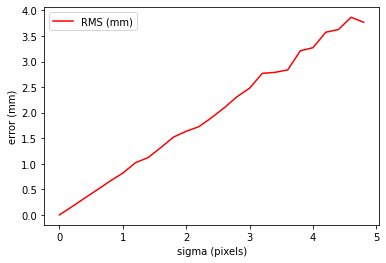

In [312]:
left_image_point = np.zeros((2))
right_image_point = np.zeros((2))
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 25, 1):
    sigma = sigma_counter / 5
    rms = 0
    for i in range(number_samples):
        left_image_point[0] = gold_left_image_point[0] + random.normalvariate(0, sigma)
        left_image_point[1] = gold_left_image_point[1] + random.normalvariate(0, sigma)
        right_image_point[0] = gold_right_image_point[0] + random.normalvariate(0, sigma)
        right_image_point[1] = gold_right_image_point[1] + random.normalvariate(0, sigma)
        left_camera_point = triangulate_points_to_3d(left_image_point, 
                                                     left_intrinsics, 
                                                     left_distortion, 
                                                     right_image_point, 
                                                     right_intrinsics, 
                                                     right_distortion, 
                                                     left_to_right)
        left_world_point = convert_camera_point_to_world(left_camera_point,
                                                         camera_to_marker,
                                                         marker_to_world
                                                        )
        diff = np.linalg.norm(gold_world_point - left_world_point)
        diff = diff * diff
        rms = rms + diff
    rms = rms / number_samples
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='RMS (mm)')  
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('error (mm)')
plt.show()

# Experiment 1: Discussion, Conclusion

So as noise increases, so does the triangulation error in millimetres. So, we know that our feature detector for triangulation purposes must be sub-pixel accuracy to get triangulation accuracy around 1mm.



# Experiment 2: Accuracy of stereo calibration

What is the effect of inaccuracies in our stereo calibration?


In [300]:
print(left2right)

[-0.18663586637738608, -1.022194275896184, -0.31552983713490357, -6.05146, 0.058148, -0.143609]


So, rotation about y axis, or translation in x-axis are of interest.


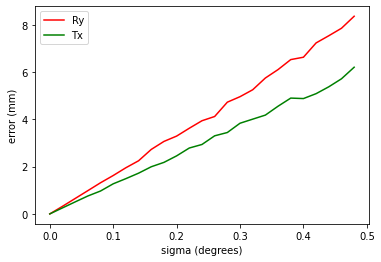

In [304]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 25, 1):
    sigma = sigma_counter / 50
    rms = 0
    for i in range(number_samples):
        tmp_left2right = copy.deepcopy(left2right)
        tmp_left2right[1] = tmp_left2right[1] + random.normalvariate(0, sigma)
        tmp_stereo_matrix = rigid_body_parameters_to_matrix(tmp_left2right)
        left_camera_point = triangulate_points_to_3d(gold_left_image_point, 
                                                     left_intrinsics, 
                                                     left_distortion, 
                                                     gold_right_image_point, 
                                                     right_intrinsics, 
                                                     right_distortion, 
                                                     tmp_stereo_matrix)
        left_world_point = convert_camera_point_to_world(left_camera_point,
                                                         camera_to_marker,
                                                         marker_to_world
                                                        )
        diff = np.linalg.norm(gold_world_point - left_world_point)
        diff = diff * diff
        rms = rms + diff
    rms = rms / number_samples
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)

rotation_values = copy.deepcopy(y_values)

# Repeat of above, just doing translation.
y_values = []
for sigma_counter in range(0, 25, 1):
    sigma = sigma_counter / 50
    rms = 0
    for i in range(number_samples):
        tmp_left2right = copy.deepcopy(left2right)
        tmp_left2right[3] = tmp_left2right[3] + random.normalvariate(0, sigma)
        tmp_stereo_matrix = rigid_body_parameters_to_matrix(tmp_left2right)
        left_camera_point = triangulate_points_to_3d(gold_left_image_point, 
                                                     left_intrinsics, 
                                                     left_distortion, 
                                                     gold_right_image_point, 
                                                     right_intrinsics, 
                                                     right_distortion, 
                                                     tmp_stereo_matrix)
        left_world_point = convert_camera_point_to_world(left_camera_point,
                                                         camera_to_marker,
                                                         marker_to_world
                                                        )
        diff = np.linalg.norm(gold_world_point - left_world_point)
        diff = diff * diff
        rms = rms + diff
    rms = rms / number_samples
    rms = np.sqrt(rms)
    y_values.append(rms)

translation_values = copy.deepcopy(y_values)

plt.plot(x_values, rotation_values, 'r', label='Ry')  
plt.plot(x_values, translation_values, 'g', label='Tx')  
plt.legend(loc='upper left')
plt.xlabel('sigma (degrees)')
plt.ylabel('error (mm)')
plt.show()    

# Experiment 2: Discussion and Conclusion

These numbers are interesting. With only 4-6mm baseline, the system is very sensitive to changes in the stereo calibration parameters. The standard deviation on both rotation and translation, should be less than tenths of a millimetre or degree. This is exceptionally hard to achieve as each calibration gives numbers that vary by more than this. This suggests that we cannot be confident about the stereo calibration, and it should probably be done once by an engineer, under lab conditions, checked, and not done by a user in the field.